In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import powerlaw
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import multiprocessing as mp
import pickle
from tqdm import tqdm

In [2]:
def estimate_gamma(g):
    degrees = [d for n, d in g.degree()]
    fit = powerlaw.Fit(degrees, discrete=True, verbose=False)
    return np.float32(fit.power_law.alpha)

In [3]:
# Load the data
N = 10_000
f = 1/N
iterations = 1e6

labels = [
    "BA_5", 
    "BA_1", 
    "ER_0-0007", 
    "ER_0-002", 
    "SF_0-1_0-1_0-8", 
    "SF_0-35_0-3_0-35", 
    "SF_0-4_0-1_0-5", 
    "SF_0-2_0-7_0-1"
]

labels2 = [
    r"BA $m=5$",
    r"BA $m=1$",
    r"ER $p=0.0007$",
    r"ER $p=0.002$",
    r"SF $\alpha=0.1$, $\beta=0.1$, $\gamma=0.8$",
    r"SF $\alpha=0.35$, $\beta=0.3$, $\gamma=0.35$",
    r"SF $\alpha=0.4$, $\beta=0.1$, $\gamma=0.5$",
    r"SF $\alpha=0.2$, $\beta=0.7$, $\gamma=0.1$"
]

networks = []
for label in labels:
  with open(f"temp_data/{label}.gpickle", "rb") as f:
      networks.append(pickle.load(f))

data = []
for label in labels:
    with open(f"temp_data/{label}.csv", "rb") as f:
        data.append(pd.read_csv(f))

estimated_gamma = [estimate_gamma(g) for g in networks]

In [4]:
data[0].tail()

,Unnamed: 0,iteration,S,T,G,A
1300737,1300737,9999948,1,1,5,1
1300738,1300738,9999959,1,1,7,1
1300739,1300739,9999967,6,5,77,6
1300740,1300740,9999973,1,1,6,1
1300741,1300741,9999982,1,1,5,1


In [5]:
def fit_tau(area, occurrences, cutoff):
    x = np.log10(area)[:cutoff]
    y = np.log10(occurrences)[:cutoff]
    # Linear fit
    fit = np.polyfit(x, y, 1)
    tau = -fit[0]
    return tau

In [6]:
def tau_from_data(data, cutoff):
    area = data.groupby("A", as_index=False).count()
    tau = fit_tau(area["A"], area['iteration'], cutoff)
    return tau

In [7]:
estimated_tau = [tau_from_data(d, 10) for d in data]

In [8]:
theoretical_tau = []
for gamma in estimated_gamma:
    if gamma < 3:
       theoretical_tau.append(gamma/(gamma - 1))
    else:
        theoretical_tau.append(1.5)

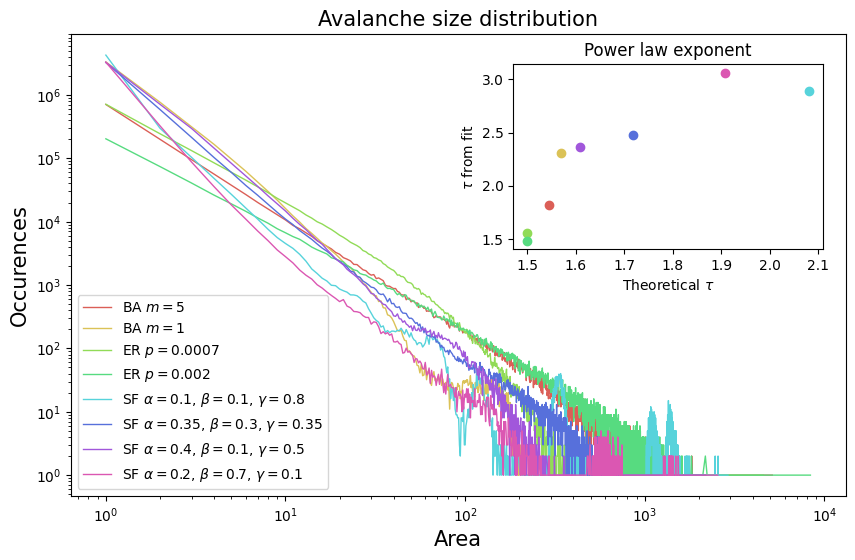

In [9]:
colors = sns.color_palette("hls", n_colors=len(labels))
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(len(labels)):
    res = data[i]
    area = res.groupby("A", as_index=False).count()
    
    ax.plot(area["A"], area["iteration"], label=labels2[i], lw=1, color=colors[i])

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Area", fontsize=15)
ax.set_ylabel("Occurences", fontsize=15)
ax.set_title("Avalanche size distribution", fontsize=15)
ax.legend(loc="lower left")

inset_ax = inset_axes(ax, width="100%", height="100%", bbox_to_anchor=(0.58, 0.55, 0.4, 0.4), bbox_transform=ax.transAxes)
for i in range(len(labels)):
    inset_ax.scatter(theoretical_tau[i], estimated_tau[i], color=colors[i])
#inset_ax.plot([1.5, 2], [1.5, 2], color="black", linestyle="--")
inset_ax.set_xlabel(r"Theoretical $\tau$")
inset_ax.set_ylabel(r"$\tau$ from fit")
inset_ax.set_title("Power law exponent");

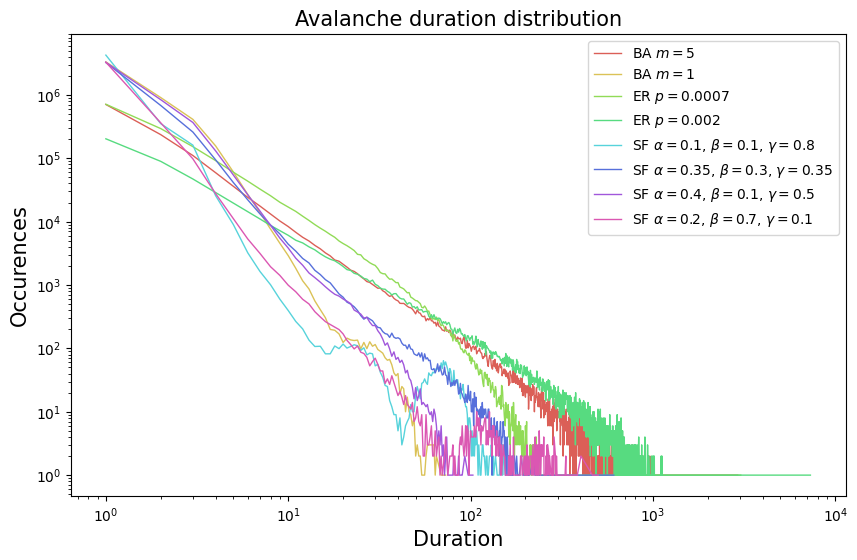

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(len(labels)):
    res = data[i]
    area = res.groupby("T", as_index=False).count()
    
    ax.plot(area["T"], area["iteration"], label=labels2[i], lw=1, color=colors[i])
    #ax.scatter(area["T"], area["iteration"], color=colors[i], s=3)

ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_xlim(1, 100)

ax.set_xlabel("Duration", fontsize=15)
ax.set_ylabel("Occurences", fontsize=15)
ax.set_title("Avalanche duration distribution", fontsize=15)
ax.legend(loc="upper right");

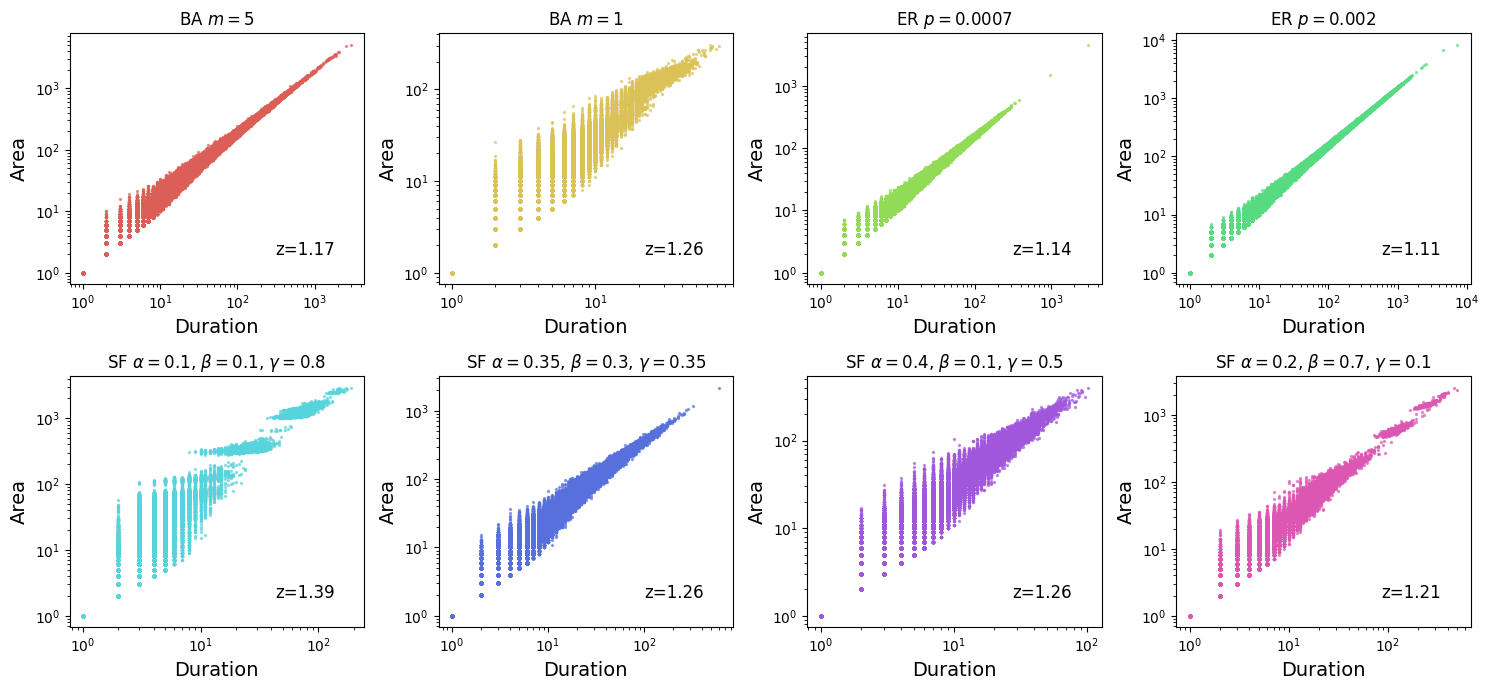

In [28]:
fig, ax = plt.subplots(2, 4, figsize=(15, 7))
for i in range(len(labels)):
    res = data[i]
    
    ax[i//4, i%4].scatter(res["T"], res["A"], label=labels2[i], color=colors[i], s=2, alpha=0.6)

    ax[i//4, i%4].set_xscale("log")
    ax[i//4, i%4].set_yscale("log")
    
    ax[i//4, i%4].set_title(labels2[i])
    ax[i//4, i%4].set_xlabel("Duration", fontsize=14)
    ax[i//4, i%4].set_ylabel("Area", fontsize=14)

    z = np.polyfit(np.log10(res["T"]), np.log10(res["A"]), 1)[0]
    ax[i//4, i%4].text(0.9, 0.1, f"z={z:.2f}", ha='right', va='bottom', transform=ax[i//4, i%4].transAxes, fontsize=12)
    #ax[i//4, i%4].plot(res["T"], 10**z * res["T"], color="black", linestyle="--", lw=1)

plt.tight_layout();

## Combine graphs

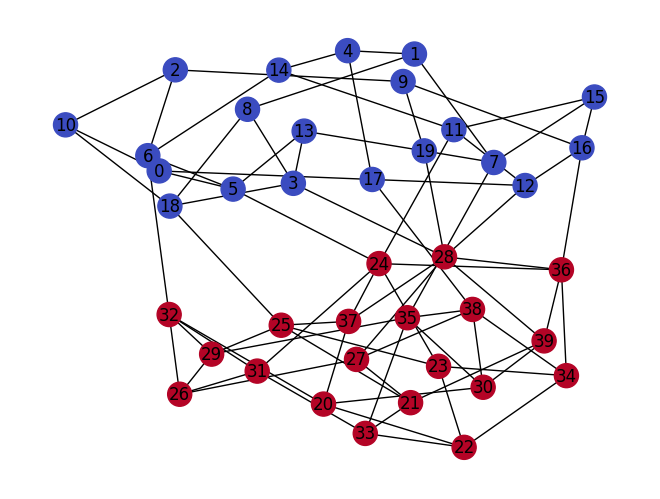

In [21]:
N = 20 # Number of nodes in each graph
p = 0.5 # Coupling probability

# Create two random regular graphs
g1 = nx.random_regular_graph(3, N)
g2 = nx.random_regular_graph(4, N)

# Relabel the nodes in the second graph
g2 = nx.relabel_nodes(g2, {i: i+N for i in g2.nodes})
belongs_to = np.zeros(2*N)
belongs_to[N:] = 1

# Combine the two graphs
g_coupled = nx.Graph()
g_coupled.add_nodes_from(g1.nodes)
g_coupled.add_edges_from(g1.edges)
g_coupled.add_nodes_from(g2.nodes)
g_coupled.add_edges_from(g2.edges)

# Bernoulli distributed coupling
for node in g1.nodes():
    if np.random.random() < p:
        # Choose a node from the second layer randomly
        node_in_layer2 = np.random.choice(list(g2.nodes()))
        g_coupled.add_edge(node, node_in_layer2, inter_layer=True)

nx.draw(g_coupled, with_labels=True, node_color=belongs_to, cmap='coolwarm')

In [22]:
def getCoupledGraph(N, p, g1=None, g2=None):
    # Create two random regular graphs
    if g1 is None: g1 = nx.random_regular_graph(3, N)
    if g2 is None: g2 = nx.random_regular_graph(3, N)

    assert len(g1.nodes) == len(g2.nodes), "g1 and g2 must have the same number of nodes"
    assert N == len(g1.nodes), "N must correspond to the number of nodes"

    # Relabel the nodes in the second graph
    g2 = nx.relabel_nodes(g2, {i: i+N for i in g2.nodes})
    belongs_to = np.zeros(2*N)
    belongs_to[N:] = 1

    # Combine the two graphs
    g_coupled = nx.Graph()
    g_coupled.add_nodes_from(g1.nodes)
    g_coupled.add_edges_from(g1.edges)
    g_coupled.add_nodes_from(g2.nodes)
    g_coupled.add_edges_from(g2.edges)

    # Bernoulli distributed coupling
    for node in g1.nodes():
        if np.random.random() < p:
            # Choose a node from the second layer randomly
            node_in_layer2 = np.random.choice(list(g2.nodes()))
            g_coupled.add_edge(node, node_in_layer2, inter_layer=True)

    return g_coupled, belongs_to

In [23]:
def coupledDynamics(g, belogs_to, f, iterations, p):
    N = g.number_of_nodes()
    degree = [d for _, d in g.degree()]

    load = np.zeros(N)
    critical_load = np.array(degree)

    res = pd.DataFrame({
        "p": [],
        "iteration": [],
        "started_in": [],
        "A_0": [],
        "A_1": [],
    })

    # Run the simulation
    for i in tqdm(range(int(iterations))):
        unstable_queue = []

        # Select a random node
        node = np.random.randint(N)
        
        # Update the load of the selected node
        load[node] += 1

        # Check if the node has become unstable
        if load[node] > critical_load[node]:
            unstable_queue.append(node)
            started_in = belogs_to[node]

        # Solve unstable queue
        A_0 = 0 # Avalanche size (ended in layer 0)
        A_1 = 0 # Avalanche size (ended in layer 1)
        while len(unstable_queue) > 0:
            # Pick the first node in the queue
            node = unstable_queue.pop(0)
            
            # Avalanche size counter
            toppled_in = belogs_to[node]
            if toppled_in == 0:
                A_0 += 1
            else:
                A_1 += 1

            # Get the neighbors of the node
            neighbors = list(g.neighbors(node))

            # Sample a fraction of the neighbors
            to_keep = np.random.rand(len(neighbors)) > f
            neighbors = [neighbors[i] for i in range(len(neighbors)) if to_keep[i]]

            # Update the load of the neighbors
            load[neighbors] += 1

            # Update the state of the node
            load[node] = 0

            # Check if the neighbors have become unstable
            unstable_neighbors = [n for n in neighbors if load[n] > critical_load[n]]
            if len(unstable_neighbors) > 0:
                unstable_queue.extend(unstable_neighbors)
                unstable_queue = list(set(unstable_queue))

        if A_0 > 0 or A_1 > 0:
            res.loc[len(res)] = {
                "p": p,
                "iteration": i,
                "started_in": started_in,
                "A_0": A_0,
                "A_1": A_1,
            }    

    return res

In [24]:
res

,Unnamed: 0,iteration,S,T,G,A
0,0,289,1,1,1,1
1,1,328,1,1,1,1
2,2,347,1,1,1,1
3,3,370,1,1,1,1
4,4,461,1,1,1,1
...,...,...,...,...,...,...
3793499,3793499,9999979,1,1,2,1
3793500,3793500,9999988,1,1,1,1
3793501,3793501,9999989,1,1,1,1
3793502,3793502,9999992,1,1,1,1


In [26]:
g_coupled, belongs_to = getCoupledGraph(1_000, 0.3)
res = coupledDynamics(g_coupled, belongs_to, 0.01, 2e5, 0.3)

100%|██████████| 200000/200000 [00:55<00:00, 3600.02it/s]


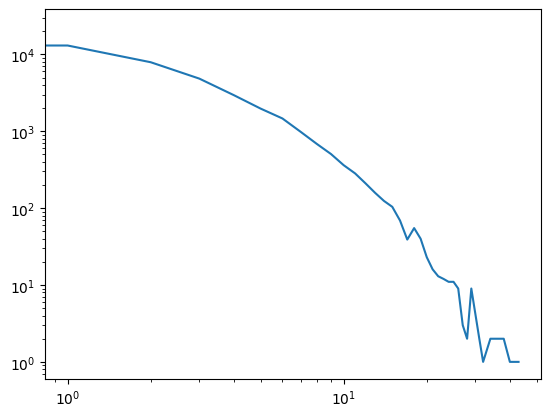

In [27]:
ok = res.groupby("A_0", as_index=False).count()
plt.plot(ok["A_0"], ok["iteration"])
plt.xscale("log")
plt.yscale("log")